## 1. Données


## 2. Traitement des données

![ELT avec duckDb](elt-duckDb.png)

### a. Objectif du traitement :

Il s'agira de catégoriser les candidats en fonction de leurs spécialités, savoir dans quelle grande université ils sont inscriptibles.
Enregistré par les différentes années provenant des fichiers, avoir une liste complète des spécialité des candidats qui permettra les classé dans les grandes universités

### b. Utilisation de DuckDB :

L'objectif ici est de prendre en main différentes méthodes de traitement qu'offre DuckDB, à savoir la création de table (temporelle, dimensions et faits) à partir du chargement d'un ou plusieurs fichier csv, utilisé SQL pour faire nos opérations d'agrégation, insert ou upsert pour les données existante, voir comment faire de l'auto incrément sur les clé primaires et divisé les données de notre table temporelle dans les tables de dimensions et de faits.


## c. Points clés et particularités :
Durant l'implémentation de notre pipeline voici les points clé remarqués
- Ne possède pas de génération incrémentale de clés primaire.
- Compatible avec SQL, il supporte la syntaxe SQL standard, ce qui simplifie l'écriture et l'exécution des requêtes.
- Installation rapide sous forme de package à installer et importé
- Persistance des données configurable, il est possible de faire tout le processus de traitement sans sauvegarde physique (persistance réelle) une fois la session fermée rien n'est persisté.
- Prends aussi en charge le format parquet, JSON etc



In [219]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [220]:
# Création et connexion de la base de données
conn = duckdb.connect('edu.db', read_only=False)

# Dossier où se trouve les fichiers csv
folder = 'edu'

table_name = "all_candidates"


In [221]:
# Requête de création de la table all_data sans traitement 
# on vas charger les données d'abord ensuite faite les traitements 
# ELT au lieu de ETL étape 1 à 2 (voir schéma du pipline)

save_all_data = f"""
    CREATE OR REPLACE TEMP TABLE {table_name} AS 
    SELECT * FROM read_csv('{folder}/**/*.csv')
"""

In [222]:
conn.execute(save_all_data)

In [223]:
# Vérification des tables créées
tables = conn.execute("SHOW TABLES").fetchall()
print("Liste des tables:", tables)

Liste des tables: [('all_candidates',)]


In [224]:
# Affichage des 5 premières juste histire de s'assurer que les données ont été charger dans la base (LOAD de ELT)
conn.execute(f"FROM {table_name}").df().head()

,nom,prenom,dateDeNaissance,lieuDeNaissance,genre,modeAdmission,sessionBac,academie,specialite,numPlaceBac,numMatricule,annee
0,ABACAR,Amadou Yacouba,1993-12-31,Tombouctou,homme,NOUVEAU_BACHELIER,2021-08-01,BASSIKOUNOU,TLL,7,21Y1M00001V,2021 - 2022
1,ABDOLLAHI,Mohamed Lamine Ag,2000-08-02,Bajakari,homme,NOUVEAU_BACHELIER,2021-08-01,BASSIKOUNOU,TLL,10,21Y1M00002W,2021 - 2022
2,ABDORAHAMANE,Khadijatou Walet,2006-12-31,Kareri / Kita,femme,NOUVEAU_BACHELIER,2021-08-01,BASSIKOUNOU,TLL,11,21Y1F00003V,2021 - 2022
3,ABDOULAYE,Mohamed Issa Ag,1996-12-31,Tombouctou,homme,NOUVEAU_BACHELIER,2021-08-01,BASSIKOUNOU,TLL,13,21Y1M00004Y,2021 - 2022
4,AGALI,Sidi Mohamed Ag,2002-11-08,Tin- Asouker,homme,NOUVEAU_BACHELIER,2021-08-01,BASSIKOUNOU,TLL,19,21Y1M00005Z,2021 - 2022


In [225]:
conn.execute(f"SELECT count(*) FROM {table_name}").fetchone()

(118720,)

In [226]:
# Création des sequences ids pour pourvoir faire de l'incrementation des ids automatique : étape 2 (voir schéma du pipline)
req_seq_ids = f"""
    CREATE SEQUENCE IF NOT EXISTS id_etablissement START 1;
    CREATE SEQUENCE IF NOT EXISTS id_year START 1;
    CREATE SEQUENCE IF NOT EXISTS id_filiere START 1;
    CREATE SEQUENCE IF NOT EXISTS id_candidate START 1;
    CREATE SEQUENCE IF NOT EXISTS id_admission START 1;
"""

conn.execute(req_seq_ids)

In [227]:
# Création des tables de dimensions : étape 2 (voir schéma du pipline)

# Pour la table dim_Établissement 
req_etablissements = f"""
CREATE TABLE IF NOT EXISTS dim_etablissement (
    id INTEGER PRIMARY KEY,
    acronym VARCHAR(50) UNIQUE,
    name VARCHAR(50)
)
"""

# Pour la table Années
req_years = f"""
CREATE TABLE IF NOT EXISTS dim_year (
    id INTEGER PRIMARY KEY,
    year VARCHAR(20) UNIQUE,
)
"""

# Pour la table Filière
req_filiere = f"""
CREATE TABLE IF NOT EXISTS dim_filiere (
    id INTEGER PRIMARY KEY,
    name VARCHAR(50) UNIQUE,
)
"""

# Pour la table Candidat
req_candidate = f"""
CREATE TABLE IF NOT EXISTS dim_candidate (
    id INTEGER PRIMARY KEY,
    nom VARCHAR(50),
    prenom VARCHAR(50),
    dateDeNaissance DATE ,
    lieuDeNaissance VARCHAR(100),
    genre VARCHAR(10),
    numPlaceBac VARCHAR(20),
    numMatricule VARCHAR(20),
    academie VARCHAR(50),
    CONSTRAINT unique_candidate UNIQUE (nom, prenom, dateDeNaissance, lieuDeNaissance, numPlaceBac, numMatricule)
)
"""

# Pour la table Admission
req_admission = f"""
CREATE TABLE IF NOT EXISTS fact_admission (
    id INTEGER PRIMARY KEY,
    candidate_id INT,
    filiere_id INT,
    year_id INT,
    etablissement_id INT,
    sessionBac DATE,
    modeAdmission VARCHAR(20),
    FOREIGN KEY (candidate_id) REFERENCES dim_candidate(id),
    FOREIGN KEY (filiere_id) REFERENCES dim_filiere(id),
    FOREIGN KEY (year_id) REFERENCES dim_year(id),
    FOREIGN KEY (etablissement_id) REFERENCES dim_etablissement(id)
)
"""


In [228]:
# Exécution des requêtes de création des tables de dimensions et de faits étape 2 entreposage (voir schéma du pipline)
conn.execute(req_etablissements)
conn.execute(req_years)
conn.execute(req_filiere)
conn.execute(req_candidate)
conn.execute(req_admission)


In [229]:
# Vérification des tables créées
tables = conn.execute("SHOW TABLES").fetchall()
print("Liste des tables:", tables)

Liste des tables: [('all_candidates',), ('dim_candidate',), ('dim_etablissement',), ('dim_filiere',), ('dim_year',), ('fact_admission',)]


In [230]:
# Insertion des établissements étape 3 (voir schéma du pipline)
insert_etablissements = """
    INSERT INTO dim_etablissement (id, acronym, name)
    VALUES (nextval('id_etablissement'), 'FST', 'Faculté des sciences et Techniques')
    ON CONFLICT (acronym) DO NOTHING;

    INSERT INTO dim_etablissement (id, acronym, name)
    VALUES (nextval('id_etablissement'), 'FSEG', 'Faculté des sciences économiques')
    ON CONFLICT (acronym) DO NOTHING;

    INSERT INTO dim_etablissement (id, acronym, name)
    VALUES (nextval('id_etablissement'), 'FLSL', 'Faculté des Lettres, des Langues et des Sciences du Langage')
    ON CONFLICT (acronym) DO NOTHING;
"""

# Insertion des années
insert_years = """
    INSERT INTO dim_year (id, year)
    SELECT nextval('id_year'), annee
    FROM (
        SELECT DISTINCT annee FROM all_candidates
    ) AS unique_years ON CONFLICT (year) DO NOTHING
"""


# Insertion des filières
insert_filiere = """
    INSERT INTO dim_filiere (id, name)
    SELECT nextval('id_filiere'), specialite
    FROM (
        SELECT DISTINCT specialite FROM all_candidates
    ) AS unique_specialites ON CONFLICT (name) DO NOTHING
"""

# Insertion des candidats
insert_candidates = """
    INSERT INTO dim_candidate (id, nom, prenom, dateDeNaissance, lieuDeNaissance, genre, numPlaceBac, numMatricule, academie)
    SELECT nextval('id_candidate'),nom, prenom, dateDeNaissance, lieuDeNaissance, UPPER(genre), numPlaceBac, numMatricule, academie
    FROM (
        SELECT DISTINCT nom, prenom, dateDeNaissance, lieuDeNaissance, genre, numPlaceBac, numMatricule, academie
        FROM all_candidates
    ) AS unique_candidates ON CONFLICT (nom, prenom, dateDeNaissance, lieuDeNaissance, numPlaceBac, numMatricule) DO NOTHING
"""


# Insertion des admissions
insert_admissions = """
    INSERT INTO fact_admission (id, candidate_id, filiere_id, year_id, etablissement_id, sessionBac, modeAdmission)
SELECT 
    nextval('id_admission'),
    c.id AS candidate_id,
    f.id AS filiere_id,
    y.id AS year_id,
    (SELECT id FROM dim_etablissement WHERE acronym = 
        CASE 
            WHEN a.specialite IN ('TSE', 'TSEXP', 'GEN', 'GMI', 'CG', 'GELN', 'GEL', 'GM', 'TSExp') THEN 'FST'
            WHEN a.specialite IN ('TSECO', 'CF', 'GCO') THEN 'FSEG'
            WHEN a.specialite IN ('TLL', 'TSS', 'TAL') THEN 'FLSL'
        END) AS etablissement_id,
    a.sessionBac,
    a.modeAdmission
FROM all_candidates a
JOIN dim_candidate c ON a.nom = c.nom AND a.prenom = c.prenom AND a.numMatricule = c.numMatricule
JOIN dim_filiere f ON a.specialite = f.name
JOIN dim_year y ON a.annee = y.year
WHERE EXISTS (SELECT 1 FROM dim_etablissement de WHERE 
    (a.specialite IN ('TSE', 'TSEXP', 'GEN', 'GMI', 'CG', 'GELN', 'GEL', 'GM', 'TSExp') AND de.acronym = 'FST') OR
    (a.specialite IN ('TSECO', 'CF', 'GCO') AND de.acronym = 'FSEG') OR
    (a.specialite IN ('TLL', 'TSS', 'TAL') AND de.acronym = 'FLSL'));
"""



In [231]:
# Execution des insert dans nos tables dimensions et table de faits etape 3 (voir schema du pipline)
conn.execute(insert_etablissements)
conn.execute(insert_years)
conn.execute(insert_filiere)
conn.execute(insert_candidates)

In [232]:
# Vérification que les données ont bien été enregistré dans les tables de dimensions
conn.execute(f"FROM dim_candidate").df().head()

,id,nom,prenom,dateDeNaissance,lieuDeNaissance,genre,numPlaceBac,numMatricule,academie
0,1949373,AHMED,Fadimata Walet,2002-01-21,Diabaly,FEMME,22,21Y1F00007Z,BASSIKOUNOU
1,1949374,ALPHA,Mohamed Ag,1997-12-31,Nouakchott,HOMME,32,21Y1M00014A,BASSIKOUNOU
2,1949375,HAMENANI,Hamama Ag,1998-12-31,DARI,HOMME,58,21Y1M00026I,BASSIKOUNOU
3,1949376,MOHAMED,Mohamed Youssouf Ag,1999-09-08,gargando,HOMME,96,21Y1M00043R,BASSIKOUNOU
4,1949377,MOHAMED ALHADI,Ousmane Ag,1997-04-24,Tombouctou,HOMME,99,21Y1M00045T,BASSIKOUNOU


In [233]:
conn.execute(insert_admissions)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [234]:
# Vérification que les données ont bien été enregistré dans la table de faits
conn.execute(f"FROM fact_admission").df().head()

,id,candidate_id,filiere_id,year_id,etablissement_id,sessionBac,modeAdmission
0,966124,1951056,120865,88,118,2021-08-01,NOUVEAU_BACHELIER
1,966125,2035925,120865,90,118,2023-08-01,NOUVEAU_BACHELIER
2,966126,2035955,120865,90,118,2023-08-01,NOUVEAU_BACHELIER
3,966127,2036774,120865,90,118,2023-08-01,NOUVEAU_BACHELIER
4,966128,2045795,120865,90,118,2023-08-01,NOUVEAU_BACHELIER
...,...,...,...,...,...,...,...
118230,1084354,2065599,120861,90,118,2023-08-01,NOUVEAU_BACHELIER
118231,1084355,2065074,120861,90,118,2023-08-01,NOUVEAU_BACHELIER
118232,1084356,2065146,120861,90,118,2023-08-01,NOUVEAU_BACHELIER
118233,1084357,2066400,120861,90,118,2023-08-01,NOUVEAU_BACHELIER


In [235]:
# Suppression de la table temporelle
conn.execute(f"DROP TABLE IF EXISTS all_candidates")

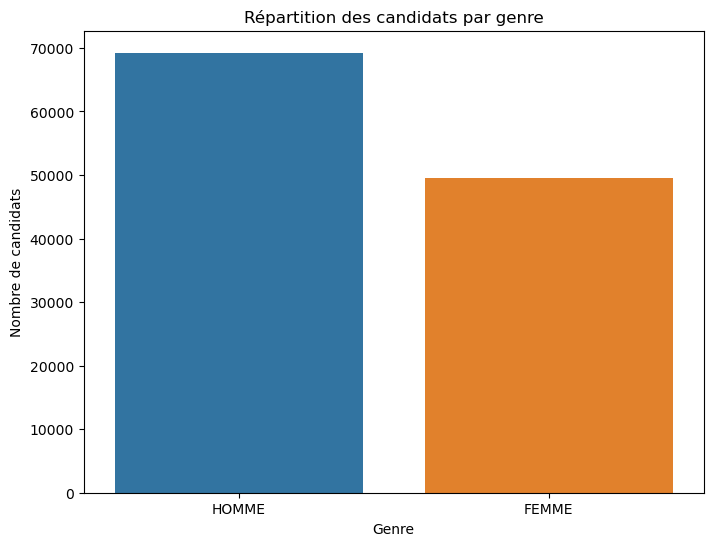

In [236]:
# Répartition des candidats par genre étape 4 (voir schéma du pipline)
candidatesByGender = conn.execute("""
    SELECT genre, COUNT(*) as count 
    FROM dim_candidate 
    GROUP BY genre;
""").df()

plt.figure(figsize=(8, 6))
sn.barplot(x='genre', y='count', data=candidatesByGender)
plt.title('Répartition des candidats par genre')
plt.xlabel('Genre')
plt.ylabel('Nombre de candidats')
plt.show()

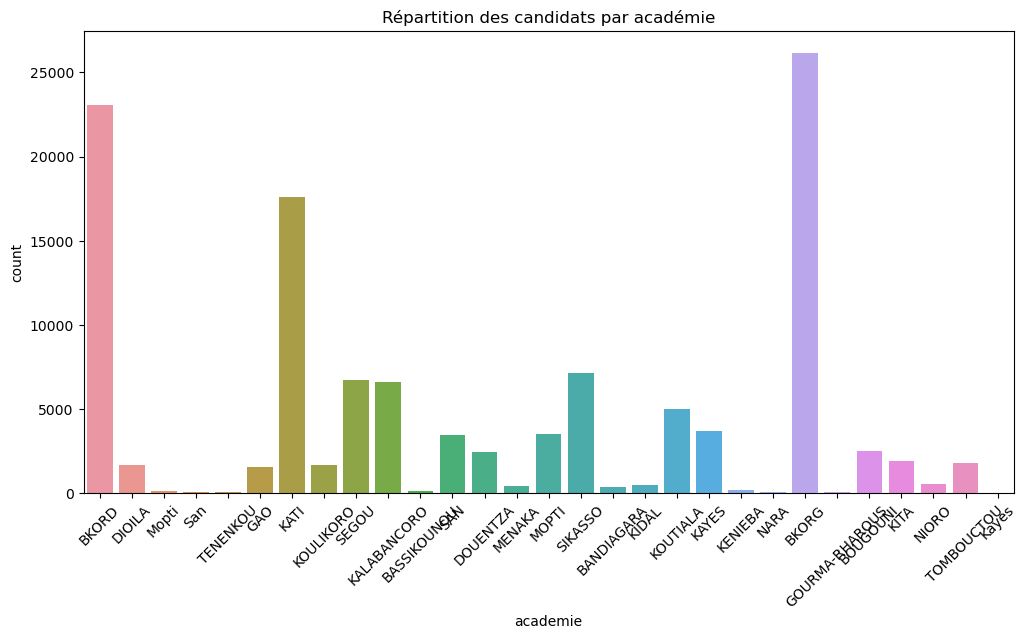

In [243]:
# Répartition des candidats par académie étape 4 (voir schéma du pipline)
candidatesByAcademy = conn.execute("""
    SELECT academie, COUNT(*) as count 
    FROM dim_candidate 
    GROUP BY academie
""").df()

plt.figure(figsize=(12, 6))
sn.barplot(x='academie', y='count', data=candidatesByAcademy)
plt.title('Répartition des candidats par académie')
plt.xticks(rotation=45)
plt.show()


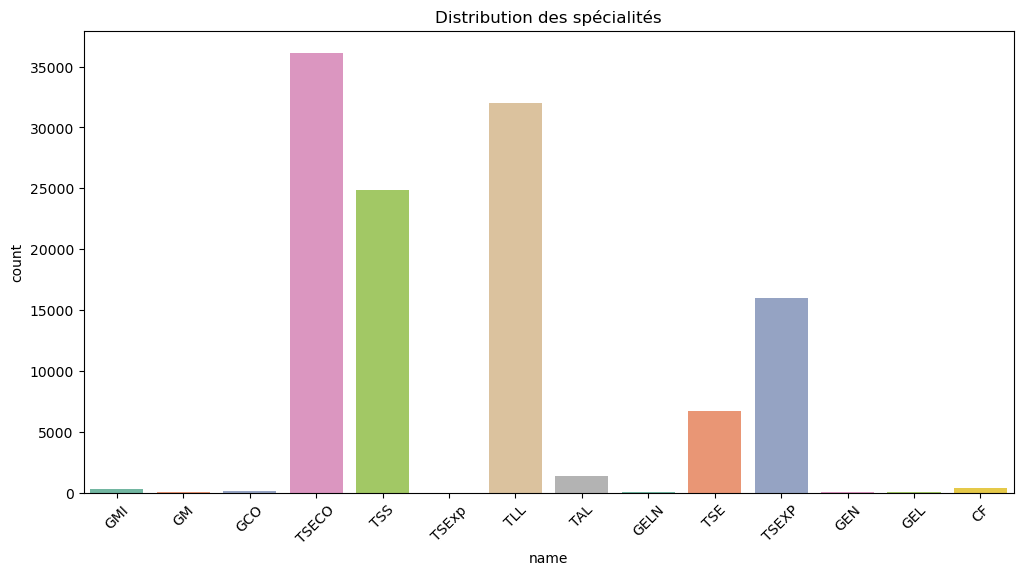

In [238]:
# Distribution des spécialités étape 4 (voir schéma du pipline)
candidatesByAcademy = conn.execute("""
    SELECT f.name, COUNT(*) as count 
    FROM fact_admission fa
    JOIN dim_filiere f ON fa.filiere_id = f.id
    GROUP BY f.name
""").df()

plt.figure(figsize=(12, 6))
sn.barplot(x='name', y='count', data=candidatesByAcademy, palette='Set2')
plt.title('Distribution des spécialités')
plt.xticks(rotation=45)
plt.show()


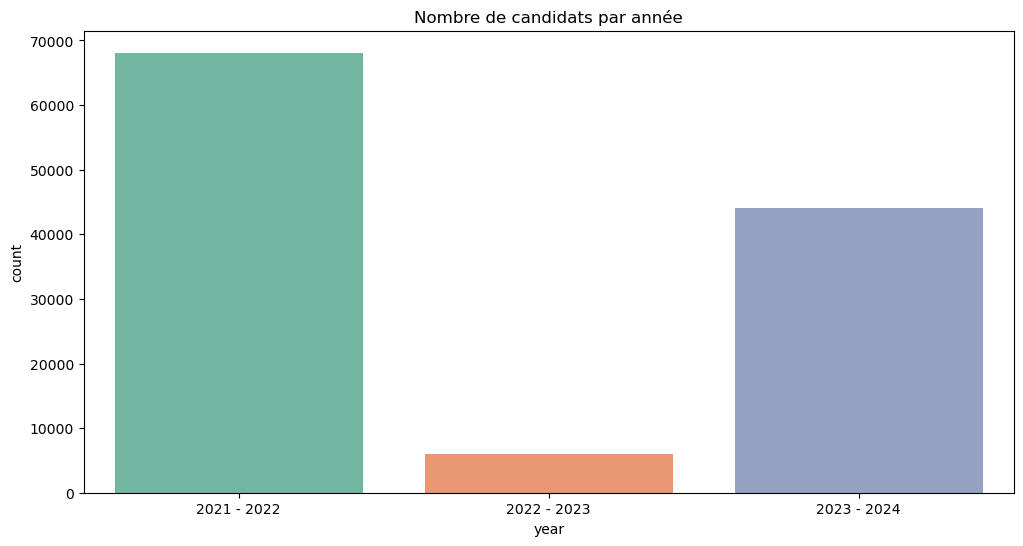

In [239]:
# Nombre de candidats par année étape 4 (voir schéma du pipline)
candidatesPerYear = conn.execute("""
    SELECT y.year, COUNT(*) as count 
    FROM fact_admission fa
    JOIN dim_year y ON fa.year_id = y.id
    GROUP BY y.year
""").df()

plt.figure(figsize=(12, 6))
sn.barplot(x='year', y='count', data=candidatesPerYear, palette='Set2')
plt.title('Nombre de candidats par année')
plt.show()


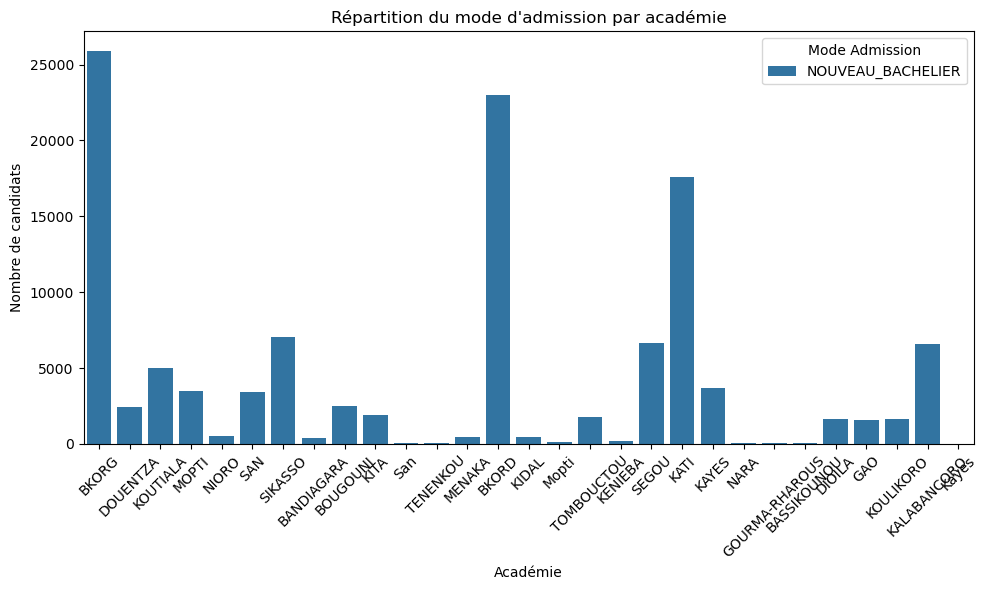

In [240]:
# Nombre de candidats par mode d'admission étape 4 (voir schéma du pipline)
modeAdmissionCount =  conn.execute("""
    SELECT c.academie, fa.modeAdmission, COUNT(*) as count 
    FROM fact_admission fa
    JOIN dim_candidate c ON fa.candidate_id = c.id
    GROUP BY c.academie, fa.modeAdmission
""").df()

plt.figure(figsize=(10, 6))
sn.barplot(x='academie', y='count', hue='modeAdmission', data=modeAdmissionCount)
plt.title('Répartition du mode d\'admission par académie')
plt.xlabel('Académie')
plt.ylabel('Nombre de candidats')
plt.xticks(rotation=45)
plt.legend(title='Mode Admission')
plt.tight_layout()
plt.show()

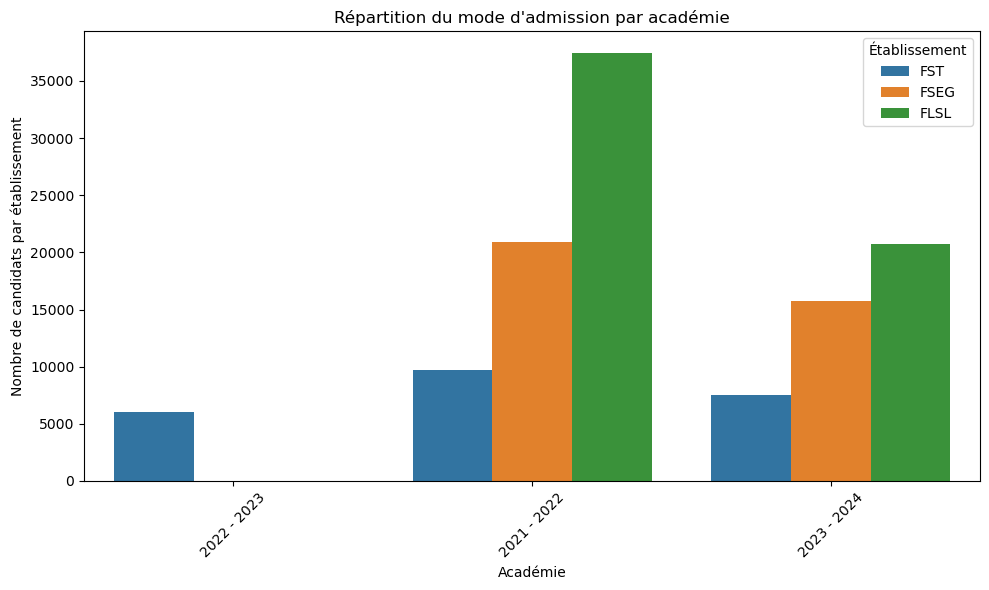

In [241]:
# Nombre de candidats par année et etablissements étape 4 (voir schéma du pipline)
candidatesPerEtablissment = conn.execute("""
    SELECT e.acronym, y.year, COUNT(*) as count 
    FROM fact_admission fa
    JOIN dim_etablissement e ON fa.etablissement_id = e.id
    JOIN dim_year y ON fa.year_id = y.id
    GROUP BY y.year, e.acronym
""").df()

plt.figure(figsize=(10, 6))
sn.barplot(x='year', y='count', hue='acronym', data=candidatesPerEtablissment)
plt.title('Répartition du mode d\'admission par académie')
plt.xlabel('Académie')
plt.ylabel('Nombre de candidats par établissement')
plt.xticks(rotation=45)
plt.legend(title='Établissement')
plt.tight_layout()
plt.show()


In [242]:
#conn.execute(f"DROP TABLE IF EXISTS fact_admission")
#conn.execute(f"DROP TABLE IF EXISTS dim_candidate")
#conn.execute(f"DROP TABLE IF EXISTS dim_filiere")
#conn.execute(f"DROP TABLE IF EXISTS dim_year")
#conn.execute(f"DROP TABLE IF EXISTS dim_etablissement")
#conn.execute(f"DROP TABLE IF EXISTS all_candidates")